## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp005'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

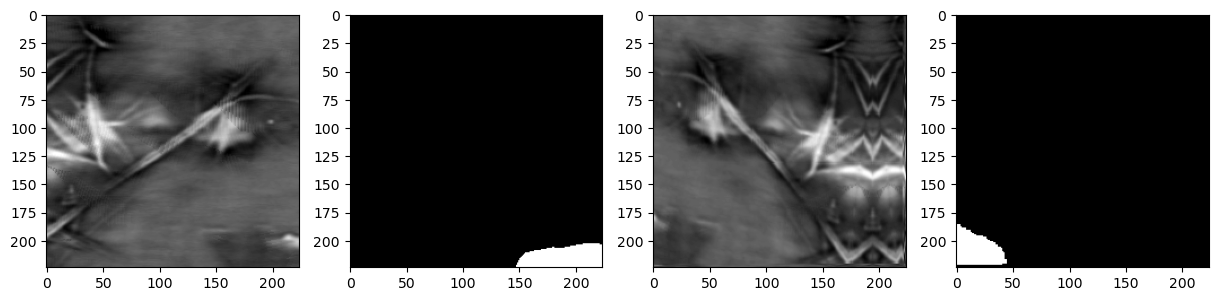

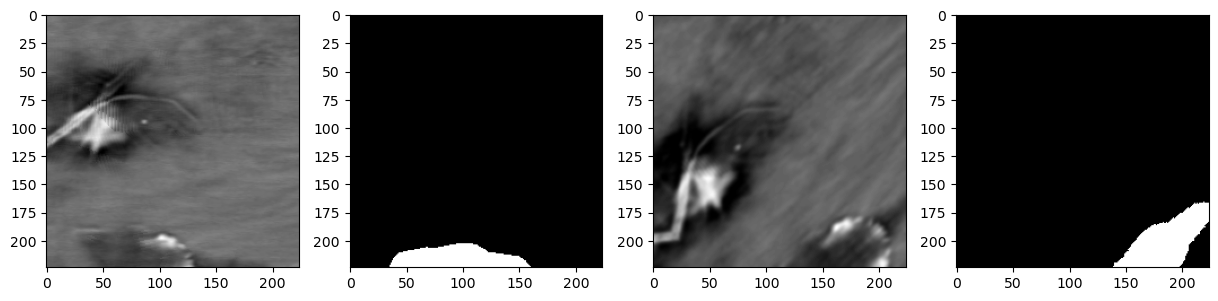

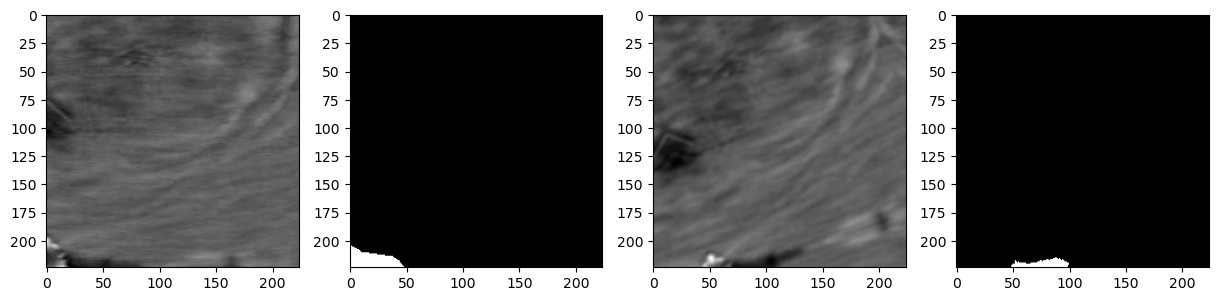

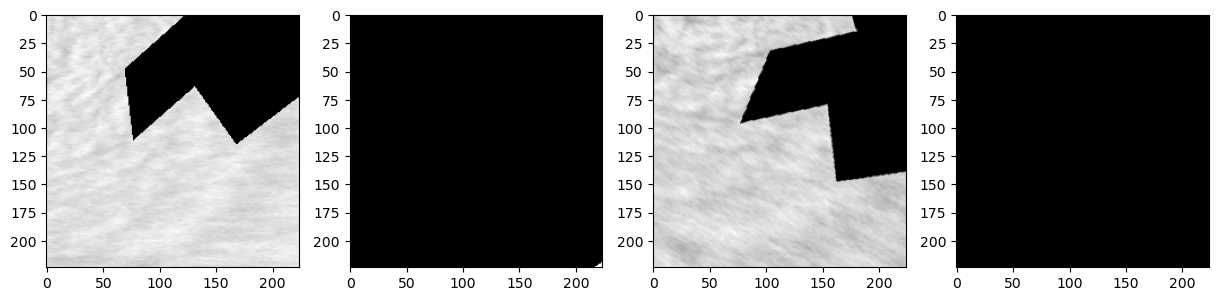

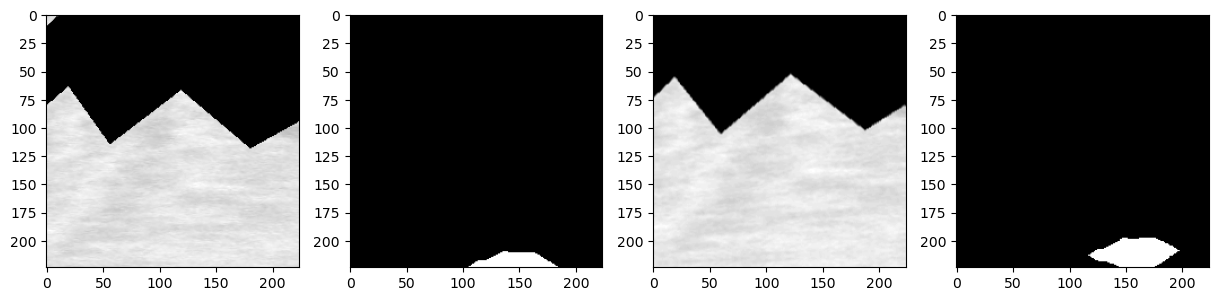

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /root/.cache/torch/hub/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth


  0%|          | 0.00/187M [00:00<?, ?B/s]

## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.15385603147055088
th: 0.15, fbeta: 0.22572138126810976
th: 0.2, fbeta: 0.24965734917127452
th: 0.25, fbeta: 0.27508572241550105
th: 0.3, fbeta: 0.3057427972091644
th: 0.35, fbeta: 0.33921129043958126
th: 0.4, fbeta: 0.3704647326730469
th: 0.45, fbeta: 0.3936898132752107


best_th: 0.5, fbeta: 0.3968810633556403
Epoch 1 - avg_train_loss: 0.4043  avg_val_loss: 0.3284  time: 225s
Epoch 1 - avgScore: 0.3969
Epoch 1 - Save Best Score: 0.3969 Model
Epoch 1 - Save Best Loss: 0.3284 Model


th: 0.5, fbeta: 0.3968810633556403


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23481964280912332
th: 0.15, fbeta: 0.2732246147756535
th: 0.2, fbeta: 0.30779510330775256
th: 0.25, fbeta: 0.338330353154772
th: 0.3, fbeta: 0.3642436969855532
th: 0.35, fbeta: 0.3886917164155059
th: 0.4, fbeta: 0.4097578489544561
th: 0.45, fbeta: 0.42454525444350966


best_th: 0.5, fbeta: 0.42967416941751246
Epoch 2 - avg_train_loss: 0.3129  avg_val_loss: 0.2851  time: 228s
Epoch 2 - avgScore: 0.4297
Epoch 2 - Save Best Score: 0.4297 Model
Epoch 2 - Save Best Loss: 0.2851 Model


th: 0.5, fbeta: 0.42967416941751246


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.3107731283003275
th: 0.15, fbeta: 0.34999934963026613
th: 0.2, fbeta: 0.3814295412956296
th: 0.25, fbeta: 0.40761381322876544
th: 0.3, fbeta: 0.43215912757815544
th: 0.35, fbeta: 0.45351625485935404
th: 0.4, fbeta: 0.4707161284769487
th: 0.45, fbeta: 0.48599098154532044


best_th: 0.5, fbeta: 0.49696118622282526
Epoch 3 - avg_train_loss: 0.2637  avg_val_loss: 0.2320  time: 227s
Epoch 3 - avgScore: 0.4970
Epoch 3 - Save Best Score: 0.4970 Model
Epoch 3 - Save Best Loss: 0.2320 Model


th: 0.5, fbeta: 0.49696118622282526


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33209815448025354
th: 0.15, fbeta: 0.35326185318247755
th: 0.2, fbeta: 0.37094000623107765
th: 0.25, fbeta: 0.3875225991282713
th: 0.3, fbeta: 0.4009346950479815
th: 0.35, fbeta: 0.4134139457341211
th: 0.4, fbeta: 0.42700878941796433
th: 0.45, fbeta: 0.4397724031587517


best_th: 0.5, fbeta: 0.44991352233381604
Epoch 4 - avg_train_loss: 0.2352  avg_val_loss: 0.2628  time: 227s
Epoch 4 - avgScore: 0.4499


th: 0.5, fbeta: 0.44991352233381604


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3280078601620758
th: 0.15, fbeta: 0.36249734709339143
th: 0.2, fbeta: 0.38930257606303803
th: 0.25, fbeta: 0.41571971200434055
th: 0.3, fbeta: 0.4387858049803063
th: 0.35, fbeta: 0.45930989206541256
th: 0.4, fbeta: 0.4763316346665832
th: 0.45, fbeta: 0.4889125474572382


best_th: 0.5, fbeta: 0.49760520970566124
Epoch 5 - avg_train_loss: 0.2239  avg_val_loss: 0.2391  time: 227s
Epoch 5 - avgScore: 0.4976
Epoch 5 - Save Best Score: 0.4976 Model
Epoch 5 - Save Best Loss: 0.2391 Model


th: 0.5, fbeta: 0.49760520970566124


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.444089245233108
th: 0.15, fbeta: 0.4757654179052383
th: 0.2, fbeta: 0.49523264528008076
th: 0.25, fbeta: 0.5066158043722275
th: 0.3, fbeta: 0.5144335548726395
th: 0.35, fbeta: 0.5167975817562255
th: 0.4, fbeta: 0.5134160852503838
th: 0.45, fbeta: 0.5081955935013943


best_th: 0.35, fbeta: 0.5167975817562255
Epoch 6 - avg_train_loss: 0.2101  avg_val_loss: 0.2655  time: 227s
Epoch 6 - avgScore: 0.5168
Epoch 6 - Save Best Score: 0.5168 Model
Epoch 6 - Save Best Loss: 0.2655 Model


th: 0.5, fbeta: 0.5015277541828245


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3590659710337064
th: 0.15, fbeta: 0.38778553900740753
th: 0.2, fbeta: 0.4143200818221268
th: 0.25, fbeta: 0.43956327071679413
th: 0.3, fbeta: 0.4593996278946067
th: 0.35, fbeta: 0.47798300480203065
th: 0.4, fbeta: 0.49418197196446223
th: 0.45, fbeta: 0.50538033036491


best_th: 0.5, fbeta: 0.514979916998879
Epoch 7 - avg_train_loss: 0.1995  avg_val_loss: 0.2484  time: 227s
Epoch 7 - avgScore: 0.5150


th: 0.5, fbeta: 0.514979916998879


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4667205372378217
th: 0.15, fbeta: 0.4957086279641219
th: 0.2, fbeta: 0.5061977158330904
th: 0.25, fbeta: 0.5116622422237733
th: 0.3, fbeta: 0.5086826991548555
th: 0.35, fbeta: 0.5024919612885047
th: 0.4, fbeta: 0.48979367308222127
th: 0.45, fbeta: 0.4713613407103227


best_th: 0.25, fbeta: 0.5116622422237733
Epoch 8 - avg_train_loss: 0.1864  avg_val_loss: 0.2732  time: 228s
Epoch 8 - avgScore: 0.5117


th: 0.5, fbeta: 0.4472763062433814


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39980922126354873
th: 0.15, fbeta: 0.42594326468515825
th: 0.2, fbeta: 0.4455210601356971
th: 0.25, fbeta: 0.453572421256874
th: 0.3, fbeta: 0.45481171897988715
th: 0.35, fbeta: 0.46079142064531553
th: 0.4, fbeta: 0.4655537918271726
th: 0.45, fbeta: 0.4604483142852752


best_th: 0.4, fbeta: 0.4655537918271726
Epoch 9 - avg_train_loss: 0.1740  avg_val_loss: 0.2847  time: 226s
Epoch 9 - avgScore: 0.4656


th: 0.5, fbeta: 0.4489819298501722


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3341449811929755
th: 0.15, fbeta: 0.35547196356644584
th: 0.2, fbeta: 0.37358960128180385
th: 0.25, fbeta: 0.38870150604453363
th: 0.3, fbeta: 0.401123270693611
th: 0.35, fbeta: 0.4117960161749727
th: 0.4, fbeta: 0.4234577373128184
th: 0.45, fbeta: 0.4347016212876495


best_th: 0.5, fbeta: 0.4448223985536095
Epoch 10 - avg_train_loss: 0.1662  avg_val_loss: 0.2937  time: 227s
Epoch 10 - avgScore: 0.4448


th: 0.5, fbeta: 0.4448223985536095


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39844689841091424
th: 0.15, fbeta: 0.4281858563633008
th: 0.2, fbeta: 0.4525269445523814
th: 0.25, fbeta: 0.47114389358060205
th: 0.3, fbeta: 0.48424723258124724
th: 0.35, fbeta: 0.49416382570999823
th: 0.4, fbeta: 0.49919523302149643
th: 0.45, fbeta: 0.5002286535961493


best_th: 0.45, fbeta: 0.5002286535961493
Epoch 11 - avg_train_loss: 0.1558  avg_val_loss: 0.3063  time: 227s
Epoch 11 - avgScore: 0.5002


th: 0.5, fbeta: 0.49807868196852484


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.417091986581688
th: 0.15, fbeta: 0.4411021616348335
th: 0.2, fbeta: 0.45720946487187436
th: 0.25, fbeta: 0.469505707772912
th: 0.3, fbeta: 0.4760020934591685
th: 0.35, fbeta: 0.47813667714916486
th: 0.4, fbeta: 0.47608446019565487
th: 0.45, fbeta: 0.47132363680213407


best_th: 0.35, fbeta: 0.47813667714916486
Epoch 12 - avg_train_loss: 0.1447  avg_val_loss: 0.3168  time: 227s
Epoch 12 - avgScore: 0.4781


th: 0.5, fbeta: 0.46355180895117293


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43158966165062396
th: 0.15, fbeta: 0.4599455761287466
th: 0.2, fbeta: 0.48158337627056613
th: 0.25, fbeta: 0.4971989904989129
th: 0.3, fbeta: 0.50866046291682
th: 0.35, fbeta: 0.5183287458553509
th: 0.4, fbeta: 0.5252218053802665
th: 0.45, fbeta: 0.5279230976898759


best_th: 0.5, fbeta: 0.5283249941083158
Epoch 13 - avg_train_loss: 0.1393  avg_val_loss: 0.2780  time: 226s
Epoch 13 - avgScore: 0.5283
Epoch 13 - Save Best Score: 0.5283 Model
Epoch 13 - Save Best Loss: 0.2780 Model


th: 0.5, fbeta: 0.5283249941083158


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.392481849207228
th: 0.15, fbeta: 0.418135750077084
th: 0.2, fbeta: 0.4347308603465668
th: 0.25, fbeta: 0.44689663673497626
th: 0.3, fbeta: 0.4560541772645679
th: 0.35, fbeta: 0.4616316098148974
th: 0.4, fbeta: 0.4654223500756863
th: 0.45, fbeta: 0.46551910679513825


best_th: 0.45, fbeta: 0.46551910679513825
Epoch 14 - avg_train_loss: 0.1283  avg_val_loss: 0.3253  time: 227s
Epoch 14 - avgScore: 0.4655


th: 0.5, fbeta: 0.46127400015792047


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3815532248815463
th: 0.15, fbeta: 0.40669895655215227
th: 0.2, fbeta: 0.4288177687665785
th: 0.25, fbeta: 0.4485901651218758
th: 0.3, fbeta: 0.4658271941843345
th: 0.35, fbeta: 0.48092447488223933
th: 0.4, fbeta: 0.49383030621588764
th: 0.45, fbeta: 0.5025024288701044


best_th: 0.5, fbeta: 0.5069574698169171
Epoch 15 - avg_train_loss: 0.1197  avg_val_loss: 0.3177  time: 227s
Epoch 15 - avgScore: 0.5070


th: 0.5, fbeta: 0.5069574698169171


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39502805740981145
th: 0.15, fbeta: 0.421894434864743
th: 0.2, fbeta: 0.44461846731627785
th: 0.25, fbeta: 0.46447181385542136
th: 0.3, fbeta: 0.48012365865196255
th: 0.35, fbeta: 0.4901204423664403
th: 0.4, fbeta: 0.4952916224505442
th: 0.45, fbeta: 0.498012218306482


best_th: 0.5, fbeta: 0.49897653711043444
Epoch 16 - avg_train_loss: 0.1135  avg_val_loss: 0.3202  time: 228s
Epoch 16 - avgScore: 0.4990


th: 0.5, fbeta: 0.49897653711043444


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4008698096505944
th: 0.15, fbeta: 0.43441783599409967
th: 0.2, fbeta: 0.46038537374416505
th: 0.25, fbeta: 0.4820777938852556
th: 0.3, fbeta: 0.4999702315837909
th: 0.35, fbeta: 0.5138268299511892
th: 0.4, fbeta: 0.5262400508146358
th: 0.45, fbeta: 0.5323862076097663


best_th: 0.5, fbeta: 0.5345864994644032
Epoch 17 - avg_train_loss: 0.1074  avg_val_loss: 0.3012  time: 228s
Epoch 17 - avgScore: 0.5346
Epoch 17 - Save Best Score: 0.5346 Model
Epoch 17 - Save Best Loss: 0.3012 Model


th: 0.5, fbeta: 0.5345864994644032


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41161004363795545
th: 0.15, fbeta: 0.4403743475686724
th: 0.2, fbeta: 0.46569427503101546
th: 0.25, fbeta: 0.4859577462027928
th: 0.3, fbeta: 0.5010296117050665
th: 0.35, fbeta: 0.5134595619597309
th: 0.4, fbeta: 0.5223033313608065
th: 0.45, fbeta: 0.5251922223864631


best_th: 0.45, fbeta: 0.5251922223864631
Epoch 18 - avg_train_loss: 0.1000  avg_val_loss: 0.3297  time: 227s
Epoch 18 - avgScore: 0.5252


th: 0.5, fbeta: 0.5234645131328272


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41725501941806026
th: 0.15, fbeta: 0.4428030211323318
th: 0.2, fbeta: 0.4642192199514275
th: 0.25, fbeta: 0.483948148210307
th: 0.3, fbeta: 0.4985664091842494
th: 0.35, fbeta: 0.5078288484678265
th: 0.4, fbeta: 0.5149223948900395
th: 0.45, fbeta: 0.5183018473613505


best_th: 0.45, fbeta: 0.5183018473613505
Epoch 19 - avg_train_loss: 0.0942  avg_val_loss: 0.3657  time: 226s
Epoch 19 - avgScore: 0.5183


th: 0.5, fbeta: 0.5159223320350091


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4088794708301262
th: 0.15, fbeta: 0.43426340574044914
th: 0.2, fbeta: 0.4539110432044433
th: 0.25, fbeta: 0.46828793516088685
th: 0.3, fbeta: 0.4778009538960048
th: 0.35, fbeta: 0.48563035779587793
th: 0.4, fbeta: 0.4915000890258627
th: 0.45, fbeta: 0.49428131818314136


best_th: 0.45, fbeta: 0.49428131818314136
Epoch 20 - avg_train_loss: 0.0904  avg_val_loss: 0.3631  time: 227s
Epoch 20 - avgScore: 0.4943


th: 0.5, fbeta: 0.4929963555361529


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42582740389010676
th: 0.15, fbeta: 0.4498527639472473
th: 0.2, fbeta: 0.46998235099912633
th: 0.25, fbeta: 0.48699279024747816
th: 0.3, fbeta: 0.4994040195920538
th: 0.35, fbeta: 0.5089866070391459
th: 0.4, fbeta: 0.5163628447918309
th: 0.45, fbeta: 0.5211048445204643


best_th: 0.45, fbeta: 0.5211048445204643
Epoch 21 - avg_train_loss: 0.0854  avg_val_loss: 0.3612  time: 227s
Epoch 21 - avgScore: 0.5211


th: 0.5, fbeta: 0.5191002306170595


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38815017192801243
th: 0.15, fbeta: 0.41537268910610636
th: 0.2, fbeta: 0.43564368724339086
th: 0.25, fbeta: 0.452737652923237
th: 0.3, fbeta: 0.46854355819372545
th: 0.35, fbeta: 0.48211066580960465
th: 0.4, fbeta: 0.493621672226832
th: 0.45, fbeta: 0.50295590314812


best_th: 0.5, fbeta: 0.5100862991014053
Epoch 22 - avg_train_loss: 0.0808  avg_val_loss: 0.3522  time: 226s
Epoch 22 - avgScore: 0.5101


th: 0.5, fbeta: 0.5100862991014053


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43697679266545697
th: 0.15, fbeta: 0.45836342863594437
th: 0.2, fbeta: 0.47300661799629296
th: 0.25, fbeta: 0.4832739857327635
th: 0.3, fbeta: 0.49191967145622145
th: 0.35, fbeta: 0.49907135374245304
th: 0.4, fbeta: 0.5063556089455746
th: 0.45, fbeta: 0.5117230721039283


best_th: 0.5, fbeta: 0.5124671700734938
Epoch 23 - avg_train_loss: 0.0766  avg_val_loss: 0.3965  time: 227s
Epoch 23 - avgScore: 0.5125


th: 0.5, fbeta: 0.5124671700734938


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4058383748029601
th: 0.15, fbeta: 0.43519670229317325
th: 0.2, fbeta: 0.45776387248308004
th: 0.25, fbeta: 0.47623896990141606
th: 0.3, fbeta: 0.4905651746494073
th: 0.35, fbeta: 0.5006940958903835
th: 0.4, fbeta: 0.5078161170226365
th: 0.45, fbeta: 0.5145959240412311


best_th: 0.5, fbeta: 0.5176195034696923
Epoch 24 - avg_train_loss: 0.0732  avg_val_loss: 0.3737  time: 228s
Epoch 24 - avgScore: 0.5176


th: 0.5, fbeta: 0.5176195034696923


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3995163277218086
th: 0.15, fbeta: 0.4229898998059923
th: 0.2, fbeta: 0.4431740611694285
th: 0.25, fbeta: 0.4609209141372605
th: 0.3, fbeta: 0.47604248312631803
th: 0.35, fbeta: 0.48812083114620153
th: 0.4, fbeta: 0.49769099749728885
th: 0.45, fbeta: 0.5068152586305618


best_th: 0.5, fbeta: 0.5117197108495131
Epoch 25 - avg_train_loss: 0.0705  avg_val_loss: 0.3810  time: 229s
Epoch 25 - avgScore: 0.5117


th: 0.5, fbeta: 0.5117197108495131


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42867796423847493
th: 0.15, fbeta: 0.44772726661530715
th: 0.2, fbeta: 0.46439765057443155
th: 0.25, fbeta: 0.47961395273192226
th: 0.3, fbeta: 0.4907036700875476
th: 0.35, fbeta: 0.5005818415584444
th: 0.4, fbeta: 0.5071040162019043
th: 0.45, fbeta: 0.5109564476756049


best_th: 0.45, fbeta: 0.5109564476756049
Epoch 26 - avg_train_loss: 0.0683  avg_val_loss: 0.4274  time: 227s
Epoch 26 - avgScore: 0.5110


th: 0.5, fbeta: 0.5072995117887085


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43193256397137814
th: 0.15, fbeta: 0.4538062279645392
th: 0.2, fbeta: 0.4685555815437395
th: 0.25, fbeta: 0.47919038233488515
th: 0.3, fbeta: 0.4906030683859627
th: 0.35, fbeta: 0.49954596908206345
th: 0.4, fbeta: 0.5059360196688969
th: 0.45, fbeta: 0.5107872643443184


best_th: 0.5, fbeta: 0.5109710766041857
Epoch 27 - avg_train_loss: 0.0664  avg_val_loss: 0.4238  time: 227s
Epoch 27 - avgScore: 0.5110


th: 0.5, fbeta: 0.5109710766041857


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42816573406807734
th: 0.15, fbeta: 0.4484379621465824
th: 0.2, fbeta: 0.4644882538371352
th: 0.25, fbeta: 0.47911567876746136
th: 0.3, fbeta: 0.4905410909898604
th: 0.35, fbeta: 0.4987642469012798
th: 0.4, fbeta: 0.5060908324344823
th: 0.45, fbeta: 0.5111150928258593


best_th: 0.5, fbeta: 0.5124228061631497
Epoch 28 - avg_train_loss: 0.0656  avg_val_loss: 0.4259  time: 226s
Epoch 28 - avgScore: 0.5124


th: 0.5, fbeta: 0.5124228061631497


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4214490403429626
th: 0.15, fbeta: 0.44306032801506057
th: 0.2, fbeta: 0.4621705357619863
th: 0.25, fbeta: 0.47595189035718394
th: 0.3, fbeta: 0.4898072927596603
th: 0.35, fbeta: 0.5010311958027732
th: 0.4, fbeta: 0.5102369660882552
th: 0.45, fbeta: 0.5167091017649108


best_th: 0.5, fbeta: 0.5184818904716042
Epoch 29 - avg_train_loss: 0.0638  avg_val_loss: 0.4127  time: 227s
Epoch 29 - avgScore: 0.5185


th: 0.5, fbeta: 0.5184818904716042


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4281142368231419
th: 0.15, fbeta: 0.4518942452890816
th: 0.2, fbeta: 0.4704365629545721
th: 0.25, fbeta: 0.4870836241482283
th: 0.3, fbeta: 0.5016810288029334
th: 0.35, fbeta: 0.5117774847734377
th: 0.4, fbeta: 0.519514947815627
th: 0.45, fbeta: 0.5246809894502945


best_th: 0.45, fbeta: 0.5246809894502945
Epoch 30 - avg_train_loss: 0.0635  avg_val_loss: 0.4066  time: 229s
Epoch 30 - avgScore: 0.5247


th: 0.5, fbeta: 0.523339705808786


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4008698096505944
th: 0.15, fbeta: 0.43441783599409967
th: 0.2, fbeta: 0.46038537374416505
th: 0.25, fbeta: 0.4820777938852556
th: 0.3, fbeta: 0.4999702315837909
th: 0.35, fbeta: 0.5138268299511892
th: 0.4, fbeta: 0.5262400508146358
th: 0.45, fbeta: 0.5323862076097663


best_th: 0.5, fbeta: 0.5345864994644032


th: 0.5, fbeta: 0.5345864994644032


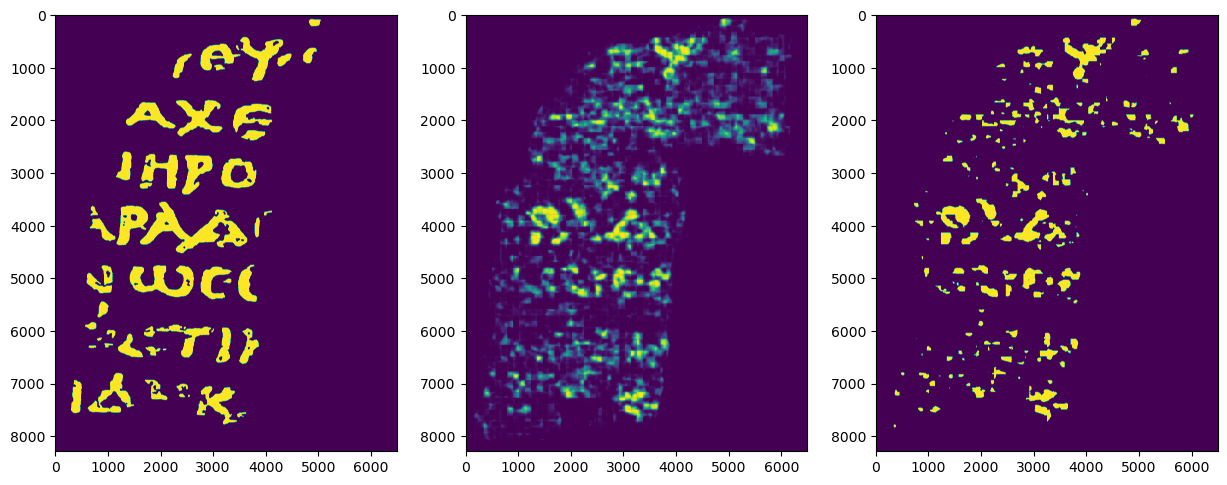

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([41151843.,  2913874.,  1812326.,  1273269.,   988351.,   820453.,
          671669.,   582997.,   482048.,   418877.,   377880.,   331556.,
          283196.,   256324.,   227511.,   217483.,   222439.,   234505.,
          268303.,   303944.]),
 array([2.84866672e-07, 4.99740230e-02, 9.99477611e-02, 1.49921499e-01,
        1.99895237e-01, 2.49868975e-01, 2.99842714e-01, 3.49816452e-01,
        3.99790190e-01, 4.49763928e-01, 4.99737666e-01, 5.49711404e-01,
        5.99685142e-01, 6.49658880e-01, 6.99632618e-01, 7.49606356e-01,
        7.99580095e-01, 8.49553833e-01, 8.99527571e-01, 9.49501309e-01,
        9.99475047e-01]),
 <BarContainer object of 20 artists>)

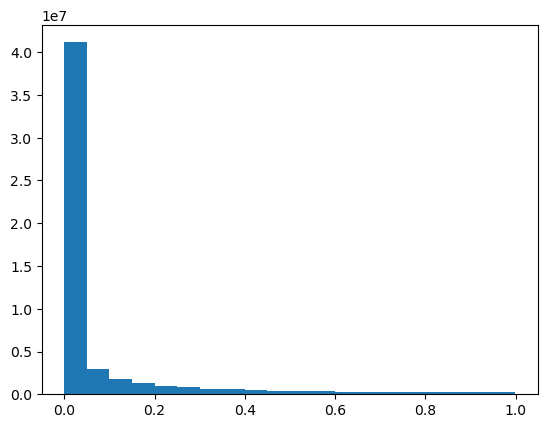

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000